Import statements

In [69]:
import json
import os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD
from learning import *

In [71]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory  # For experience replay!

In [72]:
from gym_environment_ncml import *
from learning import *

Useful numbers

In [73]:
MILLION = 1000000
HTHOUSAND = 100000
THOUSAND = 1000

## 1. Create environment ##

In [74]:
env = GridworldMultiAgentv25()

c:\Users\ANT-PC\.conda\envs\RL\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [75]:
states = env.observation_space.shape[0]
actions = env.action_space.n

In [76]:
states, actions

(10, 25)

## 2. Create a Deep Learning Model with Keras ##

In [77]:
def build_model1(states, actions, h_nodes, h_act):
    model = Sequential()
    model.add(Flatten(input_shape=(1, states)))
    for n, a in zip(h_nodes, h_act):
        model.add(Dense(n, activation=a))
    model.add(Dense(actions, activation='linear'))
    return model


In [78]:
model = build_model1(states, actions, [32, 16], ['relu', 'relu'])

In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 10)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                352       
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 25)                425       
                                                                 
Total params: 1,305
Trainable params: 1,305
Non-trainable params: 0
_________________________________________________________________


## 3. Build Agent with Keras-RL ##

In [80]:
def plot_training_metrics(name):
    """
    Visualize training metrics (rewards) for a given agent
    
    Parameters:
    -----------
    name : str
        Name of the agent/training run
    """
    # Load training data
    with open(f'agents/{name}/{name}_training.json', 'r') as f:
        data = json.load(f)
    
    # Create a figure with two subplots
    # plt.figure(figsize=(15, 10))
    
    # Rewards plot
    plt.plot(data['episode_reward'], label='Episode Reward', color='blue', alpha=0.7)
    plt.title(f'Training Rewards for {name}')
    plt.xlabel('Training Steps')
    plt.ylabel('Reward')
    plt.legend()
    
    # Optional: Add moving average for smoother visualization
    window_size = 100
    if len(data['episode_reward']) > window_size:
        rewards_ma = np.convolve(data['episode_reward'], np.ones(window_size)/window_size, mode='valid')
        plt.plot(np.arange(window_size-1, len(data['episode_reward'])), 
                 rewards_ma, label=f'{window_size}-Step Moving Average', color='red', linewidth=2)
        plt.legend()
    
    # # Loss plot
    # plt.subplot(2, 1, 2)
    # plt.plot(data['loss'], label='Training Loss', color='green', alpha=0.7)
    # plt.title(f'Training Loss for {name}')
    # plt.xlabel('Training Steps')
    # plt.ylabel('Loss')
    # plt.legend()
    
    # Adjust layout and save
    # plt.tight_layout()
    plt.savefig(f'agents/{name}/training_metrics_plot.png', dpi=300)
    # plt.close()

    # Optional: Print some basic statistics
    print(f"Reward Statistics for {name}:")
    print(f"Mean Reward: {np.mean(data['episode_reward']):.2f}")
    print(f"Max Reward: {np.max(data['episode_reward']):.2f}")
    print(f"Min Reward: {np.min(data['episode_reward']):.2f}")


In [81]:
dqn = build_agent(model, actions, 0.01, EpsGreedyQPolicy(), 50000)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
# dqn.compile(Adam(lr=1e-2), metrics=['mse'])

c:\Users\ANT-PC\.conda\envs\RL\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [82]:
# name = 'dqn25_5b5_3216_adam_lr0.001_tmu0.01_ml50K_ns5M_eps0.1_a6_b0'
name = 'DQN_simple_5HT1'

In [83]:
from rl.callbacks import Callback
import numpy as np

class LossLoggingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.episode_losses = []
        self.total_losses = []
    
    def on_episode_begin(self, episode, logs=None):
        # Reset episode losses at the start of each episode
        self.episode_losses = []
    
    def on_step_end(self, step, logs=None):
        # Capture loss at each step
        if logs is not None and 'loss' in logs:
            self.total_losses.append(logs['loss'])
            self.episode_losses.append(logs['loss'])
    
    def on_episode_end(self, episode, logs=None):
        # Compute and store mean loss for the episode if there are any losses
        if self.episode_losses:
            mean_episode_loss = np.mean(self.episode_losses)
            # You can print or log this if needed
            print(f"Episode {episode} Mean Loss: {mean_episode_loss}")



In [84]:
history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 30:39 - reward: -1.0000

c:\Users\ANT-PC\.conda\envs\RL\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 33s 3ms/step - reward: -0.4000
200 episodes - episode_reward: -20.000 [-66.000, 94.000] - loss: 2.011 - mae: 2.742 - mean_q: -0.977

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 32s 3ms/step - reward: -0.1880
200 episodes - episode_reward: -9.400 [-52.000, 104.000] - loss: 4.728 - mae: 10.134 - mean_q: 11.679

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 0.0922
200 episodes - episode_reward: 4.610 [-52.000, 132.000] - loss: 6.780 - mae: 16.419 - mean_q: 18.341

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 0.2562
200 episodes - episode_reward: 12.810 [-52.000, 132.000] - loss: 9.250 - mae: 20.923 - mean_q: 23.147

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: 0.3122
done, took 164.815 seconds


In [85]:
data = history.history
data['episode_reward'] = [float(v) for v in data['episode_reward']]
data['nb_episode_steps'] = [int(v) for v in data['nb_episode_steps']]
data['nb_steps'] = [int(v) for v in data['nb_steps']]

In [86]:
os.mkdir('agents/{}'.format(name))  # If the directory does not exist we cannot write the file
with open(get_training_path(name), 'w') as f:
    json.dump(data, f)

Save agent to memory

In [87]:
dqn.save_weights(get_agent_path(name), overwrite=True)

Reward Statistics for DQN_simple_5HT:
Mean Reward: -43.09
Max Reward: 14.00
Min Reward: -72.00


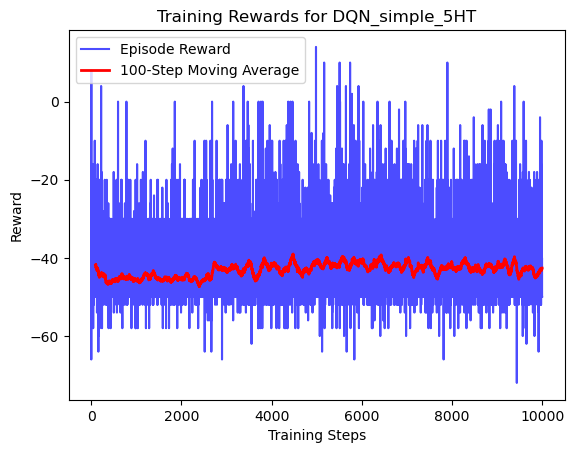

In [88]:
plot_training_metrics('DQN_simple_5HT')